In [2]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
#from tf_keras import layers, Model, models
from tensorflow.keras import layers, Model, models, metrics, optimizers
#from tensorflow import keras
import keras
import keras.backend as K
import tensorflow_datasets as tfds
import datetime
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import gc
import os
import json
tf.random.set_seed(1)

2024-11-03 13:39:35.762896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 13:39:35.783541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 13:39:35.790474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 13:39:35.804919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 13:39:36.987910: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0
Num GPUs Available:  1


I0000 00:00:1730637577.940909    1087 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730637577.970283    1087 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730637577.970365    1087 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Data wrangling

In [ ]:
full_geno_data = pd.read_csv("./data/trait_reduced_genos.csv")
full_pheno_data = pd.read_csv("./data/pheno_data/pheno_tassel_dist.csv")
geno_pheno_data = full_geno_data.merge(full_pheno_data, on = ["pop", "individual"])
ordered_geno_data = geno_pheno_data.iloc[:, 2:-3]
ordered_pheno_data = geno_pheno_data.iloc[:, -2:]
pheno_tensor = tf.convert_to_tensor(ordered_pheno_data.to_numpy())
geno_np_layers = [np.float16(ordered_geno_data.to_numpy() == cur_class) for cur_class in [-1, 0, 1]]
geno_tensor = tf.stack(geno_np_layers, axis = 1)
#geno_tensor = tf.convert_to_tensor(ordered_geno_data.iloc[:, 1:-1].to_numpy())


In [12]:
#pheno_tensor = (pheno_tensor-np.mean(pheno_tensor))

# Model definitions

In [13]:
def perc_error(y_true, y_pred):
    diff = tf.math.abs((y_true - y_pred)/y_true)
    n_samples = tf.cast(tf.shape(diff)[0], dtype=tf.float64)
    mean_per_f = tf.math.reduce_sum(diff, axis = 0)/n_samples
    return mean_per_f

def error_per_feature_mean(y_true, y_pred):
    return perc_error((tf.cast(y_true[:, 0], tf.float64)), tf.cast(y_pred[:, 0], tf.float64))

def error_per_feature_sd(y_true, y_pred):
    return perc_error((tf.cast(y_true[:, 1], tf.float64)), tf.cast(y_pred[:, 1], tf.float64))

def mean_y(y_true, y_pred):
    return tf.math.reduce_mean(y_pred)

def std_y(y_true, y_pred):
    return tf.math.reduce_std(y_pred)

In [14]:
# Define the autoencoder model
fc_reg = keras.regularizers.L2(1e-4)
l_relu = layers.LeakyReLU(negative_slope=0.5)
class trait_pred(Model):
    def __init__(self, width = 5, depth = 5):
        super().__init__()
        self.blocks = []

        for cur_sub_id in range(width):
            cur_sub_block = []
            
            #cur_sub_block.append(layers.LSTM(128))
            #cur_sub_block.append(l_relu)
            cur_sub_block.append(layers.Conv1D(filters = 5, kernel_size = 2, data_format = "channels_first"))
            cur_sub_block[len(cur_sub_block)-1].name = f"conv1_w_{cur_sub_id}"
            cur_sub_block.append(layers.Conv1D(filters = 5, kernel_size = 2, data_format = "channels_first"))
            cur_sub_block[len(cur_sub_block)-1].name = f"conv2_w_{cur_sub_id}"
            #cur_sub_block.append(layers.SpatialDropout1D(rate = 0.75))
            cur_sub_block.append(layers.MaxPool1D(pool_size=2, data_format = "channels_first"))
            cur_sub_block.append(layers.Conv1D(filters = 5, kernel_size = 2, data_format = "channels_first"))
            cur_sub_block[len(cur_sub_block)-1].name = f"conv3_w_{cur_sub_id}"
            cur_sub_block.append(layers.Conv1D(filters = 5, kernel_size = 2, data_format = "channels_first"))
            cur_sub_block[len(cur_sub_block)-1].name = f"conv4_w_{cur_sub_id}"
            #cur_sub_block.append(layers.SpatialDropout1D(rate = 0.75))
            cur_sub_block.append(layers.MaxPool1D(pool_size=2, data_format = "channels_first"))
            cur_sub_block.append(layers.Flatten())
            for layer_id in range(depth, 1, -1):
                cur_sub_block.append(layers.Dense(units=layer_id ** 4, activation=None))#, kernel_regularizer=fc_reg))#, kernel_regularizer=fc_reg))    
                cur_sub_block[len(cur_sub_block)-1].name = f"dense_{layer_id}_w_{cur_sub_id}"
                cur_sub_block.append(l_relu)
            
            cur_sub_block.append(layers.Dense(units=2, activation=None, kernel_regularizer=fc_reg))
            cur_sub_block[len(cur_sub_block)-1].name = f"dense_final_w_{cur_sub_id}"
            cur_sub_block.append(l_relu)
            self.blocks.append(cur_sub_block)
    
    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        pass
    
    def call(self, x):
        outputs = []
        for cur_block in self.blocks:
            #print(x.shape)
            sub_x = x
            #print(f"in shape: {sub_x.shape}")
            for cur_layer in cur_block:
                sub_x = cur_layer(sub_x)
            outputs.append(sub_x)
        #y = sub_x
        y = tf.math.reduce_sum(outputs, axis = 0)
        #print(x.shape)
        #print(y.shape)
        #y = tf.concat(outputs, axis = 1)
        return y

# Grid testing

In [4]:
def fit_per_para(depth, width, epochs = 100):
    print("###########################################")
    print(f"depth: {depth}")
    print(f"width: {width}")
    trait_loss = tf.keras.losses.MAE
    trait_optimizer = optimizers.Adam(learning_rate=1e-4, use_ema = True, gradient_accumulation_steps = 10)# ema_overwrite_frequency = int(1e3))
    trait_model = trait_pred(depth=depth, width=width)
    trait_model.compile(optimizer=trait_optimizer, loss = trait_loss, run_eagerly=False,
                  metrics=[error_per_feature_mean, error_per_feature_sd])
    model_train_loss = trait_model.fit(x=geno_tensor, y=pheno_tensor, epochs=epochs, shuffle=True,
              batch_size = 32, validation_split = 0.3)
    del trait_model
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    return model_train_loss

In [5]:
paras = list(itertools.product(list(range(5,0,-1)),list(range(5,0, -1))))
#paras = list(itertools.product([5],list(range(1,5)))) + list(itertools.product(list(range(1,5)),[5])) + [(5,5)]
# paras_l = list(itertools.product(list(range(10,5, -1)), list(range(10,0, -1)))) + list(itertools.product(list(range(5,0, -1)), list(range(10,5, -1))))

In [ ]:
res_per_para = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 50) for cur_paras in paras]
#res_per_paral = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 200) for cur_paras in paras]

In [70]:
res_dict = {str(paras[cur_para_id]):[res_per_para[cur_para_id].history] for cur_para_id in range(len(paras))}
res_out = open("geno_to_trait_5.txt", "w")
res_out.write(json.dumps(res_dict))
res_out.close()

In [74]:
res_deep_encoder_thining = json.loads(open("./geno_to_trait_5.txt").read())

In [77]:
res_deep_encoder_thining
dt_keys = list(res_deep_encoder_thining.keys())

In [88]:
res_deep_encoder_thining = json.loads(open("./geno_to_trait_5.txt").read())
dt_keys = list(res_deep_encoder_thining.keys())
dt_mean_error = np.array([res_deep_encoder_thining[cur_dict][0]["error_per_feature_mean"] for cur_dict in dt_keys])
dt_mean_error_df = pd.DataFrame(dt_mean_error)
dt_mean_error_df["fit"] = dt_keys
dt_mean_error_df.to_csv("./data/dt_mean_error_df_5.csv")
dt_sd_error = np.array([res_deep_encoder_thining[cur_dict][0]["error_per_feature_sd"] for cur_dict in dt_keys])
dt_sd_error_df = pd.DataFrame(dt_sd_error)
dt_sd_error_df["fit"] = dt_keys
dt_sd_error_df.to_csv("./data/dt_sd_error_df_5.csv")
dt_loss = np.array([res_deep_encoder_thining[cur_dict][0]["loss"] for cur_dict in dt_keys])
dt_loss_df = pd.DataFrame(dt_loss)
dt_loss_df["fit"] = dt_keys
dt_loss_df.to_csv("./data/dt_loss_df_5.csv")
dt_mean_error_val = np.array([res_deep_encoder_thining[cur_dict][0]["val_error_per_feature_mean"] for cur_dict in dt_keys])
dt_mean_error_val_df = pd.DataFrame(dt_mean_error_val)
dt_mean_error_val_df["fit"] = dt_keys
dt_mean_error_val_df.to_csv("./data/dt_mean_error_val_df_5.csv")
dt_sd_error_val = np.array([res_deep_encoder_thining[cur_dict][0]["val_error_per_feature_sd"] for cur_dict in dt_keys])
dt_sd_error_val_df = pd.DataFrame(dt_sd_error_val)
dt_sd_error_val_df["fit"] = dt_keys
dt_sd_error_val_df.to_csv("./data/dt_sd_error_val_df_5.csv")
dt_loss_val = np.array([res_deep_encoder_thining[cur_dict][0]["val_loss"] for cur_dict in dt_keys])
dt_loss_val_df = pd.DataFrame(dt_loss_val)
dt_loss_val_df["fit"] = dt_keys
dt_loss_val_df.to_csv("./data/dt_loss_val_df_5.csv")



#dt_train_df.to_csv("./data/geno_to_trait_5_train.csv", sep=",")



# Individual models

In [15]:
full_dataset = tf.data.Dataset.from_tensor_slices((geno_tensor, tf.cast(pheno_tensor, tf.float64)))
full_dataset = full_dataset.shuffle(buffer_size=4689)
train_dataset = full_dataset.take(3500)
test_dataset = full_dataset.skip(3500)
train_dataset = train_dataset.batch(256, drop_remainder=True)
test_dataset = test_dataset.batch(256, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [16]:
trait_loss = tf.keras.losses.MeanAbsolutePercentageError
trait_optimizer = optimizers.Adam(learning_rate=5e-5)#, use_ema = True, gradient_accumulation_steps = 20)#, ema_overwrite_frequency = int(1e3))# ema_overwrite_frequency = int(1e3))
trait_model = trait_pred(5,5)
trait_model.compile(optimizer=trait_optimizer, loss = trait_loss, run_eagerly=False,
                  metrics=[error_per_feature_mean, error_per_feature_sd, mean_y, std_y])#, error_per_feature_sd])
# cur_sample_range = 4689

In [17]:
#model_train_loss = trait_model.fit(x=geno_tensor[1:cur_sample_range, ...], y=pheno_tensor[1:cur_sample_range, ...], epochs=200, shuffle=True,
#              batch_size = 512, validation_data = (geno_tensor[1:cur_sample_range, ...], pheno_tensor[1:cur_sample_range, ...]))#, validation_split = 0.3
model_train_loss = trait_model.fit(train_dataset, epochs=200, shuffle=True,
                                    validation_data = test_dataset)#, validation_split = 0.3

Epoch 1/200


I0000 00:00:1730637717.862973   21755 service.cc:146] XLA service 0x7f11c400e210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730637717.863059   21755 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-03 13:41:58.200520: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-03 13:41:59.498923: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1730637725.590854   21755 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step - error_per_feature_mean: 1.0086 - error_per_feature_sd: 0.4870 - loss: 74.7802 - mean_y: 2.6918 - std_y: 3.3913 - val_error_per_feature_mean: 0.9986 - val_error_per_feature_sd: 0.1880 - val_loss: 59.3313 - val_mean_y: 5.0254 - val_std_y: 4.9313
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - error_per_feature_mean: 0.9879 - error_per_feature_sd: 0.1909 - loss: 58.9406 - mean_y: 4.8898 - std_y: 3.9610 - val_error_per_feature_mean: 0.9571 - val_error_per_feature_sd: 0.1836 - val_loss: 57.0359 - val_mean_y: 6.6639 - val_std_y: 3.3281
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - error_per_feature_mean: 0.9422 - error_per_feature_sd: 0.1824 - loss: 56.2304 - mean_y: 7.2239 - std_y: 2.7380 - val_error_per_feature_mean: 0.8832 - val_error_per_feature_sd: 0.1803 - val_loss: 53.1777 - val_mean_y: 8.8885 - val_std_y: 0.5697
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - error_per_feature_mean: 0.8587 - error_per_feature_sd: 0.16

W0000 00:00:1730638121.004993    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.028715    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.034436    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.040240    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.045823    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.053453    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.060890    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.069480    1087 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730638121.080483    1087 gp

prediction mean: 44.054073333740234
prediction std: 34.55856704711914
actual mean: 44.31400684441329
actual std: 34.54647713508473
min val loss at epoch 185, with loss 2.062840700149536


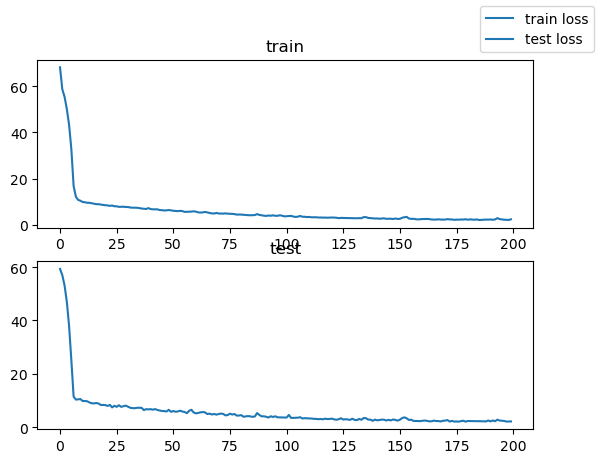

In [18]:
# 2.4513978958129883
print(f"prediction mean: {tf.math.reduce_mean(trait_model(geno_tensor))}")
print(f"prediction std: {tf.math.reduce_std(trait_model(geno_tensor))}")
print(f"actual mean: {tf.math.reduce_mean(pheno_tensor)}")
print(f"actual std: {tf.math.reduce_std(pheno_tensor)}")

print(f"min val loss at epoch {np.argmin(model_train_loss.history["loss"])}, with loss {np.min(model_train_loss.history["loss"])}")
fig, ax = plt.subplots(2, 1)
x = list(range(len(model_train_loss.history["loss"][:])))
ax[0].plot(x, model_train_loss.history["loss"][:], label = "train loss")
ax[0].set_title("train")
ax[1].plot(x, model_train_loss.history["val_loss"][:], label = "test loss")
ax[1].set_title("test")
fig.legend()

# Decoded vs Original test performance

In [33]:
encoded_geno_data = pd.read_csv("./encoded_genos.csv")

In [34]:
encoded_geno_data.to_numpy()[:,1:-2]

array([[-0.5019278 ,  0.21966708, -2.128821  , ...,  0.11372423,
         1.7746875 ,  0.2573352 ],
       [-5.636034  ,  0.6945125 , -5.019508  , ...,  2.2420797 ,
         2.0053096 , -4.107233  ],
       [-4.845539  ,  2.9260306 , -0.7969849 , ..., -4.7422986 ,
        -0.18514264,  0.36160707],
       ...,
       [-2.3181791 ,  3.2075682 , -5.0336213 , ...,  1.4756436 ,
        -5.990866  , -3.416877  ],
       [-1.983616  , -1.3229249 ,  0.12046754, ...,  4.24702   ,
         0.47681546, -3.0414276 ],
       [-4.052743  ,  1.8644639 ,  0.73127866, ..., -1.6134224 ,
         0.91961396, -5.664474  ]])

In [35]:
decoded_geno_data = pd.read_csv("./decoded_genos.csv")
ordered_decoded_geno_pheno = decoded_geno_data.merge(full_pheno_data, on = ["pop", "individual"])#.iloc[:, 1:-5]
ordered_decoded_geno_data = ordered_decoded_geno_pheno.iloc[:, 1:-5]
ordered_decoded_pheno_data = ordered_decoded_geno_pheno.iloc[:, -2:].to_numpy()
decoded_geno_np_layers = [np.float16(ordered_decoded_geno_data.to_numpy() == cur_class) for cur_class in [-1, 0, 1]]
decoded_geno_tensor = tf.stack(decoded_geno_np_layers, axis = 1)

In [48]:
ordered_decoded_pheno_data

array([[80.66666667, 11.43095213],
       [72.57142857,  8.03859737],
       [82.66666667, 12.32341944],
       ...,
       [82.33333333,  7.52772653],
       [84.16666667, 10.96205577],
       [91.4       , 15.97811003]])

In [37]:
print(error_per_feature_mean(trait_model(geno_tensor), pheno_tensor.numpy()))
print(error_per_feature_sd(trait_model(geno_tensor), pheno_tensor.numpy()))

tf.Tensor(0.012285032963825042, shape=(), dtype=float64)
tf.Tensor(0.05058575539227407, shape=(), dtype=float64)


In [38]:
print(error_per_feature_mean(trait_model(decoded_geno_tensor), ordered_decoded_pheno_data))
print(error_per_feature_sd(trait_model(decoded_geno_tensor), ordered_decoded_pheno_data))

tf.Tensor(0.10010120661441835, shape=(), dtype=float64)
tf.Tensor(0.29116853344347726, shape=(), dtype=float64)


# Feature Importance

In [33]:
class_freqs = np.unique(ordered_geno_data.iloc[:, 1:-1].to_numpy(), return_counts=True)[1]/(geno_tensor.shape[0]*geno_tensor.shape[2])
class_freqs += (1-np.sum(class_freqs))/3
inv_class_freqs = (1-class_freqs)/2

In [18]:
rand_geno_mat = np.random.choice([-1, 0, 1], replace=True,
                                size=(geno_tensor.shape[0], geno_tensor.shape[2]))
rand_geno_np_layers = [np.float16(rand_geno_mat == cur_class) for cur_class in [-1, 0, 1]]
rand_geno_tensor = tf.stack(rand_geno_np_layers, axis = 1)
print(rand_geno_tensor.shape)
rand_pred = trait_model(rand_geno_tensor)
#print(rand_pred.shape)
cur_mean_error = error_per_feature_mean(rand_pred, tf.convert_to_tensor(ordered_pheno_data))
print(f"mean error: {cur_mean_error}")
cur_sd_error = error_per_feature_sd(rand_pred, tf.convert_to_tensor(ordered_pheno_data))
print(f"sd error: {cur_sd_error}")

(4689, 3, 1144)
mean error: 0.09986565958622189
sd error: 0.3089496709462761


In [34]:
test_batch_genos = []
test_batch_labels = []
for batch in test_dataset:
    genos, labels = batch
    test_batch_genos.append(genos)
    test_batch_labels.append(labels)
test_geno_tensor = tf.concat(test_batch_genos, axis = 0)
test_labels_tensor = tf.concat(test_batch_labels, axis = 0)
test_geno_np = np.array(test_geno_tensor)

2024-11-02 17:39:51.048765: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [174]:
rand_feature = np.random.choice([-1, 0, 1], size = 1024, p = class_freqs)#, )
rand_geno_np = copy.deepcopy(test_geno_np)
rand_feature_layers = np.array([np.float16(rand_feature == cur_class) for cur_class in [-1, 0, 1]]).T

In [195]:
#rand_geno_data = ordered_geno_data.iloc[:, 1:-1].to_numpy()
mean_error = []
sd_error = []
for feature_id in np.arange(geno_tensor.shape[2]):#np.arange(geno_tensor.shape[2] - 1, -1, -1):
    rand_feature = np.random.choice([-1, 0, 1], size = 1024, p = inv_class_freqs)#, )a , p = 1
    rand_geno_np = copy.deepcopy(test_geno_np)
    rand_feature_layers = np.array([np.float16(rand_feature == cur_class) for cur_class in [-1, 0, 1]]).T
    rand_geno_np[..., feature_id] = rand_feature_layers
    rand_feature_tensor = tf.convert_to_tensor(rand_geno_np)
    rand_pred = trait_model(rand_feature_tensor)
    #print(rand_pred.shape)
    cur_mean_error = error_per_feature_mean(rand_pred, tf.convert_to_tensor(test_labels_tensor))
    mean_error.append(cur_mean_error)
    print(f"Feature {feature_id} mean error: {cur_mean_error}")
    cur_sd_error = error_per_feature_sd(rand_pred, tf.convert_to_tensor(test_labels_tensor))
    sd_error.append(cur_sd_error)
    print(f"Feature {feature_id} sd error: {cur_sd_error}")

Feature 0 mean error: 0.00976023284083565
Feature 0 sd error: 0.04641949130442734
Feature 1 mean error: 0.009938740189232336
Feature 1 sd error: 0.0461340257942395
Feature 2 mean error: 0.009759380941532836
Feature 2 sd error: 0.04461492386986981
Feature 3 mean error: 0.009872234890983843
Feature 3 sd error: 0.04582593297196322
Feature 4 mean error: 0.009595342119736444
Feature 4 sd error: 0.04647549157872075
Feature 5 mean error: 0.009744447657191327
Feature 5 sd error: 0.045642901159485466
Feature 6 mean error: 0.009658822671941205
Feature 6 sd error: 0.05029020280776422
Feature 7 mean error: 0.009796947462307746
Feature 7 sd error: 0.05067861603938006
Feature 8 mean error: 0.009719458887888293
Feature 8 sd error: 0.05009398067557884
Feature 9 mean error: 0.009461019264198397
Feature 9 sd error: 0.05132606872791599
Feature 10 mean error: 0.009468143103286855
Feature 10 sd error: 0.05424636022556915
Feature 11 mean error: 0.009650577168822144
Feature 11 sd error: 0.05645725129864519
F

In [218]:
normal_mean_error = error_per_feature_mean(trait_model(test_geno_tensor), test_labels_tensor)
normal_sd_error = error_per_feature_sd(trait_model(test_geno_tensor), test_labels_tensor)
mean_error_diff = mean_error-normal_mean_error
sd_error_diff = sd_error-normal_sd_error

In [197]:
np.sort(mean_error_diff)

array([-0.00034228, -0.00031038, -0.00027948, ...,  0.00132764,
        0.00133783,  0.00156592])

In [198]:
pd_error_dict = {"mean_error": mean_error_diff, "sd_error":sd_error_diff}
pd_error_df = pd.DataFrame(pd_error_dict)

In [199]:
pd_error_df.to_csv("./data/geno_to_trait/feature_importance/error_per_feature_inv_dist.csv")

# Model analysis

In [10]:
conv_layers = [cur_layer for cur_layer in trait_model.layers if "conv" in cur_layer.name]

In [47]:
test_geno_np[0, ...]

array([[1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.]], dtype=float16)

In [117]:
conv_layers[0]((test_geno_np[0, ...])[np.newaxis, ...])

<tf.Tensor: shape=(1, 5, 1143), dtype=float32, numpy=
array([[[-0.7063538 , -0.7063538 , -0.7063538 , ..., -0.21981649,
         -0.39610526, -0.53006506],
        [-0.01602706, -0.01602706, -0.01602706, ...,  0.6170607 ,
          0.6084559 , -0.00742223],
        [-0.32834187, -0.32834187, -0.32834187, ...,  0.0422303 ,
          0.3080718 , -0.5941833 ],
        [-0.5784454 , -0.5784454 , -0.5784454 , ..., -0.2262388 ,
          0.2109918 , -1.015676  ],
        [-0.03816957, -0.03816957, -0.03816957, ..., -0.84236574,
          0.07137086, -0.9519062 ]]], dtype=float32)>

In [190]:
conv_layers_w = [cur_layer.weights[0].numpy().reshape((2, -1)) for cur_layer in conv_layers]
conv_layers_name = [cur_layer.name for cur_layer in conv_layers]
conv_layers_sizes = [cur_layer.weights[0].numpy().reshape((2, -1)).shape[1]  for cur_layer in conv_layers]
conv_layers_b = [cur_layer.weights[1].numpy() for cur_layer in conv_layers]

In [192]:
conv_layers_sizes

[15,
 25,
 25,
 25,
 15,
 25,
 25,
 25,
 15,
 25,
 25,
 25,
 15,
 25,
 25,
 25,
 15,
 25,
 25,
 25]

In [174]:
conv_layers_w[1].reshape((2, -1))

array([[ 0.35245278,  0.42252812,  0.3783867 ,  0.05006307, -0.0164929 ,
         0.32094878, -0.5230513 , -0.28575942,  0.13842772, -0.13316181,
         0.10125662,  0.5206835 ,  0.24437985, -0.08751173, -0.4316076 ,
        -0.23525985,  0.37181178, -0.3756453 ,  0.21013638,  0.18132803,
         0.23490478,  0.00410893, -0.48986253, -0.04967552, -0.3421635 ],
       [-0.2802172 , -0.02203154, -0.11444332, -0.25928947,  0.12938072,
        -0.19522038, -0.3309158 ,  0.2417316 , -0.18534468, -0.3558753 ,
         0.20612845,  0.09938324,  0.09407976, -0.02435165, -0.18862215,
         0.31245008,  0.17441463, -0.26104745,  0.18190943,  0.28646377,
         0.3641369 , -0.15825146,  0.18086699,  0.44926313,  0.5129537 ]],
      dtype=float32)

In [169]:
conv_layers_w[0].reshape((-1, 2))

array([[-0.19561268, -0.52654666],
       [-0.06975678, -0.49872005],
       [-0.5198652 , -0.49798912],
       [-0.63263357, -0.38935927],
       [ 0.31734255, -0.5899491 ],
       [ 0.11463584,  0.09793629],
       [ 0.5666569 ,  0.29071712],
       [-0.41032478, -0.51088184],
       [ 0.51024914, -0.2591015 ],
       [-0.08115409,  0.48222852],
       [-0.47090247, -0.2469977 ],
       [-0.23892531, -0.18423788],
       [-0.2141539 , -0.3345931 ],
       [ 0.51885396, -0.524943  ],
       [-0.5183847 , -0.43150812]], dtype=float32)

In [156]:
np.sum(np.abs(conv_layers_w[0]), axis = -3)
np.sum(np.abs(conv_layers_w[1]), axis = -3)
np.sum(np.abs(conv_layers_w[2]), axis = -3)
np.sum(np.abs(conv_layers_w[3]), axis = -3)

array([[1.4592816 , 1.7037277 ],
       [1.0758189 , 1.5326701 ],
       [1.329602  , 1.3795505 ],
       [1.6561198 , 0.98697174],
       [1.1039399 , 1.2406312 ]], dtype=float32)

In [151]:
np.apply_over_axes(np.sum, a = np.abs(conv_layers_w[1]), axes = -3)

array([[[1.2199235, 0.8053622],
        [1.4013491, 1.3090878],
        [1.3854394, 0.6125653],
        [1.3741814, 1.2162853],
        [1.1207153, 1.665472 ]]], dtype=float32)

In [152]:
np.apply_over_axes(np.sum, a = np.abs(conv_layers_w[2]), axes = -3)

array([[[0.99635243, 0.80788326],
        [2.1729684 , 1.4239918 ],
        [0.7869248 , 1.469985  ],
        [1.425834  , 1.0751635 ],
        [1.070663  , 1.4218858 ]]], dtype=float32)

In [153]:
np.apply_over_axes(np.sum, a = np.abs(conv_layers_w[3]), axes = -3)

array([[[1.4592816 , 1.7037277 ],
        [1.0758189 , 1.5326701 ],
        [1.329602  , 1.3795505 ],
        [1.6561198 , 0.98697174],
        [1.1039399 , 1.2406312 ]]], dtype=float32)

In [116]:
np.sum((conv_layers_w[0].T * (test_geno_np[0, :, :2])[np.newaxis, ...]), axis = -1)

array([[-0.7064945 ,  0.        ,  0.        ],
       [-0.01629752,  0.        ,  0.        ],
       [-0.3288583 ,  0.        ,  0.        ],
       [-0.57987416,  0.        ,  0.        ],
       [-0.0376367 ,  0.        ,  0.        ]], dtype=float32)

In [63]:
conv_layers_w[0][1][0]

array([-0.51088184,  0.51024914, -0.2591015 , -0.08115409,  0.48222852],
      dtype=float32)

In [62]:
conv_layers_w[0][0][0]

array([-0.19561268, -0.52654666, -0.06975678, -0.49872005, -0.5198652 ],
      dtype=float32)

In [58]:
conv_layers_b[0]

array([ 0.00014075,  0.00027046,  0.00051641,  0.00142877, -0.00053287],
      dtype=float32)

In [202]:
test_layer = trait_model.layers[0]

In [232]:
test_w = test_layer.weights

In [234]:
test_w[0]

<KerasVariable shape=(2, 3, 5), dtype=float32, path=trait_pred_1/conv1d_24/kernel>

In [216]:
test_geno_tensor.shape

TensorShape([1024, 3, 1144])

In [220]:
np.sum(test_w.numpy(), axis =2)

array([[ 0.13892868,  1.0332233 ,  1.3910799 ],
       [-1.9692951 ,  0.9006059 ,  0.11577383]], dtype=float32)